# Size matching

Q: How often do masses match with unique sequences depending on their size

* First calculate the number of matched sequences by length
* Filter the database so we only use spectra with correct answer of size 10
* Print a distribution
    * Given that we found a sequence of size 10, how often do we find a sequence of size 9,...1

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from testing_framework import testing_utils
from preprocessing import preprocessing_utils, merge_search
import database

ppm_tolerance = 20
max_peptide_length = 23

import matplotlib.pyplot as plt

In [2]:
datasets = testing_utils.define_data()

dataset = datasets[0]

input_spectra_path = [os.path.join(dataset[0], 'NOD2_E3.mzML')]
peak_filter, relative_abundance_filter = 25, 0.1
input_spectra, boundaries = preprocessing_utils.load_spectra(input_spectra_path, ppm_tolerance, peak_filter=peak_filter, relative_abundance_filter=relative_abundance_filter)

correct_sequences = testing_utils.generate_truth_set(datasets[0])

path = dataset[2]
db = database.build(path)

In [3]:
write_path = os.path.abspath(os.path.join(module_path, 'intermediate_files'))
matched_masses_b, matched_masses_y, kmer_set = merge_search.modified_match_masses(boundaries, db, max_peptide_length, True, write_path)
print('Finished matching masses')

On protein 279/279 [100%]
Sorting the set of protein masses...
Sorting the set of protein masses done
Performing Merge
Done
Finished matching masses


In [4]:
def organize_matched_masses_by_length(matched_masses_b, matched_masses_y):
    all_mm = dict()
    all_mm.update(matched_masses_b)
    all_mm.update(matched_masses_y)
    mm_by_size =  dict()
    for mm in all_mm.keys():
        for kmer in all_mm[mm]:
            seq = kmer[2]
            if len(seq) not in mm_by_size.keys():
                mm_by_size[len(seq)] = 0
            mm_by_size[len(seq)] = mm_by_size[len(seq)] + 1
    return mm_by_size

o_mm = organize_matched_masses_by_length(matched_masses_b, matched_masses_y)
print(o_mm)

{1: 7281148, 2: 2249034, 3: 451721, 4: 471341, 5: 380779, 6: 395573, 7: 374160, 8: 361124, 9: 330855, 10: 304236, 11: 271298, 12: 246479, 13: 220825, 14: 202225, 15: 182548, 16: 159640, 17: 131637, 18: 108175, 19: 88006, 20: 69205, 21: 53127, 22: 40599, 23: 30297}


Text(0, 0.5, 'Number of explanations for a sequence of that length')

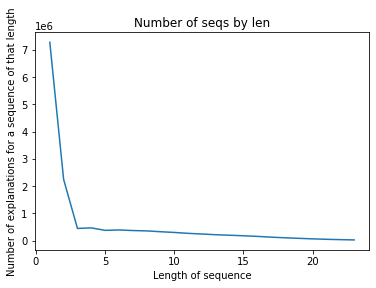

In [5]:
plt.plot(o_mm.keys(), [o_mm[x] for x in o_mm.keys()])
plt.title("Number of seqs by len")
plt.xlabel("Length of sequence")
plt.ylabel("Number of explanations for a sequence of that length")

In [6]:
from utils import hashable_boundaries

def get_unique_matched_masses(boundaries, matched_masses_b, matched_masses_y):
    unique_b,unique_y = dict(), dict()
    for mz in boundaries.keys():
        unique_b[mz],unique_y[mz] = [],[]
        for x in matched_masses_b[mz]:
            seq = x[2]
            charge = x[5]
            if seq not in unique_b[mz]:
                unique_b[mz].append(seq)
        for x in matched_masses_y[mz]:
            seq = x[2]
            charge = x[5]
            if seq not in unique_y[mz]:
                unique_y[mz].append(seq)
    return unique_b, unique_y

unique_b,unique_y = get_unique_matched_masses(boundaries, matched_masses_b, matched_masses_y)

In [7]:
def organize_matched_masses_by_length(matched_masses_b, matched_masses_y):
    all_mm = dict()
    all_mm.update(matched_masses_b)
    all_mm.update(matched_masses_y)
    mm_by_size =  dict()
    for mm in all_mm.keys():
        for seq in all_mm[mm]:
            if len(seq) not in mm_by_size.keys():
                mm_by_size[len(seq)] = 0
            mm_by_size[len(seq)] = mm_by_size[len(seq)] + 1
    return mm_by_size
u_mm = organize_matched_masses_by_length(unique_b, unique_y)
print(u_mm)

{1: 754, 2: 4561, 3: 27877, 4: 253017, 5: 352226, 6: 383240, 7: 364762, 8: 353191, 9: 323972, 10: 299072, 11: 267108, 12: 243223, 13: 217969, 14: 199662, 15: 180608, 16: 158041, 17: 130432, 18: 107269, 19: 87334, 20: 68743, 21: 52751, 22: 40392, 23: 30127}


Text(0, 0.5, 'Number of explanations for a sequence of that length')

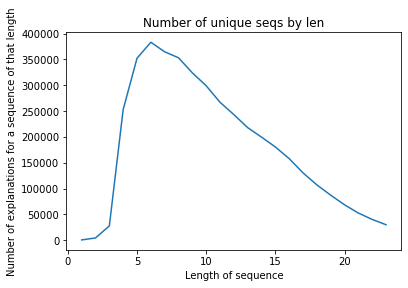

In [8]:
plt.plot(u_mm.keys(), [u_mm[x] for x in u_mm.keys()])
plt.title("Number of unique seqs by len")
plt.xlabel("Length of sequence")
plt.ylabel("Number of explanations for a sequence of that length")

# Single Spectrum

Want to know:
* Probability of seeing mass given that a cluster is correct (P(E|H))
    * Go through each cluster and assume it is correct. The defining mass has a prob of 1. Want to know how often we would find other masses
    * In a perfect world, we would find every mass in the correct cluster but that is not true
    * We can start by doing an analysis on correct hits to see how likely hits are by their size
        * Cap the size to 10 to start and then gradually increase it
        * Find hits from unique_b or unique_y
* How often do we find a correct hit?
   * By definition, the precursor is correct with probability 1 but what about other m/z values.

In [9]:
def filter_spectra_by_size(correct_answers, spectra, size_lim):
    new_spectra = []
    for i, spectrum in enumerate(spectra):
        if len(correct_answers[i]) <= size_lim:
            new_spectra.append(spectrum)
    return new_spectra

In [10]:
size_lim = 10
target_spectra = filter_spectra_by_size(correct_sequences, input_spectra, size_lim)
print(len(target_spectra))

227


# Algorithm idea

1. For each spectrum in target spectra
    * Create hits
    * Find the good hits
    * Create extensions from those good hits. Remember to include base kmers in case of no good b and y hit
    * Remove duplicate extensions
    * For that extension, look at how frequently each mass was found
2. Plot mass frequency by size. Can use a histogram of 20 weight

In [11]:
def modified_get_unique_matched_masses(spectrum, matched_masses_b, matched_masses_y):
    unique_b,unique_y = dict(),dict()
    for mz in spectrum.mz_values:
        unique_b[mz],unique_y[mz] = [],[]
        for x in matched_masses_b[mz]:
            seq = x[2]
            charge = x[5]
            if seq not in unique_b[mz]:
                unique_b[mz].append(seq)
        for x in matched_masses_y[mz]:
            seq = x[2]
            charge = x[5]
            if seq not in unique_y[mz]:
                unique_y[mz].append(seq)
    return unique_b, unique_y

def find_hits_from_unique_mm(unique_b, unique_y, spectrum):
    b_h, y_h = [], []
    for mz in spectrum.mz_values:
        if mz in unique_b:
            for seq in unique_b[mz]:
#                 hit = (mz, seq)
                b_h.append(seq)
        if mz in unique_y:
            for tup in unique_y[mz]:
#                 hit = (mz, seq)
                y_h.append(seq)    
    return b_h, y_h

In [12]:
spectrum_num = 0
target_spectrum = target_spectra[spectrum_num]
unique_b, unique_y = modified_get_unique_matched_masses(target_spectrum, matched_masses_b, matched_masses_y)

In [13]:
ubh,ybh = find_hits_from_unique_mm(unique_b, unique_y, target_spectrum)
print(ubh)

['T', 'TT', 'K', 'KK', 'SVVY', 'VVSY', 'VVYS', 'YSVV', 'YVSV', 'ITAY', 'LYTA', 'AITY', 'YTAL', 'LATY', 'TALY', 'IATY', 'YTLA', 'LTAY', 'LYAT', 'TAIY', 'IYAT', 'ALTY', 'TLYA', 'YIAT', 'YTIA', 'YTAI', 'AYLT', 'AYIT', 'ATYL', 'ALYT', 'YATI', 'TAYI', 'TSIF', 'TLSF', 'FIST', 'FITS', 'FLST', 'LFST', 'LSTF', 'SLTF', 'TFLS', 'FTSL', 'LTFS', 'IFTS', 'IFST', 'STLF', 'TLFS', 'TFSL', 'FSTI', 'FSLT', 'FSTL', 'SFLT', 'SLFT', 'STFI', 'TSFL', 'SIFT', 'SFIT', 'ISFT', 'TTFV', 'FVTT', 'VTFT', 'TVTF', 'VTTF', 'HLAE', 'EALH', 'ELAH', 'LHEA', 'LEHA', 'HLEA', 'ELHA', 'PAANP', 'LEAH', 'HEAL', 'LAEH', 'HIAE', 'EHLA', 'EHIA', 'AIEH', 'EHAL', 'EAHI', 'LHAE', 'HAEL', 'VDHV', 'PPAAN', 'AHEI', 'EAHL', 'DVHV', 'AHLE', 'LAHE', 'AHIE', 'ALHE', 'DVVH', 'APPNA', 'AELH', 'AEHL', 'AEHI', 'VVDH', 'GPQPA', 'GGPAPA', 'QP', 'AGP', 'PAG', 'PQ', 'PGA', 'APG', 'GAP', 'GPA', 'PPQQ', 'GPAPQ', 'GAPPQ', 'PAAGPG', 'AAGPPG', 'AQPPG', 'AGPQP', 'QPQP', 'QQPP', 'PQPQ', 'PQQP', 'AQGPP', 'QGAPP', 'AGGPAP', 'FFGV', 'VFFG', 'FGFV', 'FVFG', '

In [ ]:
def Cluster_seqs():

    
clusters = Cluster_seqs()

In [11]:
def filter_database_by_size(size_num, db):
    

size_num = 10
filtered_database = filter_database_by_size(size_num, db)

SyntaxError: invalid syntax (<ipython-input-11-a1ff437a43f0>, line 1)